# Team 63
## Hypothests Testing Mobility During Pandemic

### Texas Mobility During COVID Pandemic

During the pandemic we had shutdown periods around the globe to reduce the spread of the virus.  We would like to see where people were going during the pandemic and if there are any changes related to shutdown periods during that time period.

In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings

warnings.filterwarnings("ignore")  # Suppress all warnings

## Data Background

We are using data google captured of mobility during the pandemic.  This data compared each day to the baseline of mobility for various categories to show where people were going during the year.  The baseline is limited to the first 5 weeks of the year before changes were made.  The data looks at the count of visits to parks, workplace, transit, grocery/pharmacy, and retail/recreation. It also tracks residential as time spent at home compared to the baseline.  **The baseline is January 2020 and the beginning of February 2020** before any shutdowns went in affect. Note: In some locations, weather in January and February is vastly different from weather in March or April and could impact things like park visits. Since we are only considering counties in Texas, the difference in average temperature may have an affect but since the average high difference is +10 degrees per month, it may be negligible.

In [2]:
#read mobility report csv downloaded from Google
mobility = pd.read_excel("../data/mobilityreport01092021_original.xlsx")
print(mobility.columns)
print(mobility.info())

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11200 entries, 0 to 11199
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   country_region_code                                 11032 non-null  object        
 1   country_region                                      11032 non-null  object        
 2   sub_region_1                            

In [3]:
mobility.head(5)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-15,3.0,-1.0,NaN,3.0,3.0,NaN
1,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-16,8.0,2.0,NaN,9.0,-3.0,NaN
2,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-17,1.0,3.0,NaN,16.0,-18.0,3.0
3,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-18,1.0,-1.0,NaN,10.0,0.0,-1.0
4,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-19,0.0,-3.0,NaN,2.0,3.0,1.0


We decided to look at the major metroplex areas and their surrounding counties to see what people were doing.  I created a list of counties for the state, and each metroplex to use when filtering data.  We need to create datasets to find the avg percent from baseline for each category.  

In [4]:
#create list of counties that make up Texas cities and counties within major metroplex areas
Texas_Counties = ['Bastrop County','Bexar County','Caldwell County','Comal County','Guadalupe County','Hays County','Travis County','Williamson County',
    'Collin County', 'Dallas County', 'Denton County', 'Ellis County', 'Hood County', 'Hunt County', 'Johnson County', 'Kaufman County', 'Parker County', 'Rockwall County', 'Somervell County', 'Tarrant County', 'Wise County',
    'Austin County', 'Brazoria County', 'Chambers County', 'Fort Bend County', 'Galveston County', 'Harris County', 'Liberty County', 'Montgomery County', 'Waller County',
    'Atascosa County','Bandera County','Kendall County','Medina County','Wilson County']
Austin_Metroplex =  ['Bastrop County','Caldwell County','Hays County','Travis County','Williamson County']
Dallas_Metroplex = ['Collin County', 'Dallas County', 'Denton County', 'Ellis County', 'Hood County', 'Hunt County', 'Johnson County', 'Kaufman County', 'Parker County', 'Rockwall County', 'Somervell County', 'Tarrant County', 'Wise County']
Houston_Metroplex = ['Austin County', 'Brazoria County', 'Chambers County', 'Fort Bend County', 'Galveston County', 'Harris County', 'Liberty County', 'Montgomery County', 'Waller County']
San_Antonio_Metroplex = ['Atascosa County','Bandera County','Bexar County','Comal County','Guadalupe County','Kendall County','Medina County','Wilson County']

In [5]:
#create new dataset filtering by all texas counties in our scope from Texas_Counties list using na=False for nan in filtered column
mobility_tx = mobility[mobility['sub_region_1'].str.contains('Texas', na=False)]
mobility_tx = mobility_tx[mobility_tx['sub_region_2'].isin(Texas_Counties)]
#get rid of null dates
mobility_tx = mobility_tx.dropna(subset=['date'])
#delete iso_3166_2_code and census_fips_code column since we do not need it
mobility_tx.drop(['iso_3166_2_code', 'census_fips_code'], axis=1, inplace=True)
#metro_area was not populated but we will populate based on counties we chose for each metroplex
#create conditions list
conditions = [(mobility_tx['sub_region_2'].isin(Austin_Metroplex)),
             (mobility_tx['sub_region_2'].isin(Dallas_Metroplex)),
             (mobility_tx['sub_region_2'].isin(Houston_Metroplex)),
             (mobility_tx['sub_region_2'].isin(San_Antonio_Metroplex))]
#create list of metroplex values
metro = ['Austin Metroplex', 'Dallas Metroplex', 'Houston Metroplex', 'San Antonio Metroplex']
#update metro_area with values based on conditions
mobility_tx['metro_area'] = np.select(conditions, metro)
mobility_tx.head(5)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-15,3.0,-1.0,NaN,3.0,3.0,NaN
1,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-16,8.0,2.0,NaN,9.0,-3.0,NaN
2,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-17,1.0,3.0,NaN,16.0,-18.0,3.0
3,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-18,1.0,-1.0,NaN,10.0,0.0,-1.0
4,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-19,0.0,-3.0,NaN,2.0,3.0,1.0


In [6]:
#Use melt function to create a long format
#create list for id_vars(columns to keep)
other_vars = ['country_region_code', 'country_region','sub_region_1', 'sub_region_2', 'metro_area','date']
#create list for value_vars using difference to get all columns not in id_vars
val_vars = mobility_tx.columns.difference(other_vars)
#use melt to create new long format and create 2 new column names for destination and percent from baseline
mobility_tx1 = mobility_tx.melt(id_vars=other_vars, value_vars=val_vars, var_name='Destination', value_name='PercentChange')
#add columns for weeks and months
mobility_tx1['Month'] = mobility_tx1['date'].dt.month
mobility_tx1['WeekNumber'] = mobility_tx1['date'].dt.week
mobility_tx1['Year'] = mobility_tx1['date'].dt.year
mobility_tx1.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,date,Destination,PercentChange,Month,WeekNumber,Year
0,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-15,grocery_and_pharmacy_percent_change_from_baseline,-1.0,2,7,2020
1,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-16,grocery_and_pharmacy_percent_change_from_baseline,2.0,2,7,2020
2,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-17,grocery_and_pharmacy_percent_change_from_baseline,3.0,2,8,2020
3,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-18,grocery_and_pharmacy_percent_change_from_baseline,-1.0,2,8,2020
4,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-19,grocery_and_pharmacy_percent_change_from_baseline,-3.0,2,8,2020


In [7]:
#Create dict for Destination short name
#Get distinct destination names
mobility_tx1['Destination'].unique()
#create dictionary to use for short names
destination_shortdict = {'grocery_and_pharmacy_percent_change_from_baseline': 'grocery and pharmacy',
       'parks_percent_change_from_baseline': 'parks',
       'residential_percent_change_from_baseline': 'residential',
       'retail_and_recreation_percent_change_from_baseline': 'retail and recreation',
       'transit_stations_percent_change_from_baseline': 'transit stations',
       'workplaces_percent_change_from_baseline': 'workplaces'}
#replace destination column with short destination name
mobility_tx1['Destination'] = mobility_tx1['Destination'].apply(lambda x: destination_shortdict[x])
mobility_tx1

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,date,Destination,PercentChange,Month,WeekNumber,Year
0,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-15,grocery and pharmacy,-1.0,2,7,2020
1,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-16,grocery and pharmacy,2.0,2,7,2020
2,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-17,grocery and pharmacy,3.0,2,8,2020
3,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-18,grocery and pharmacy,-1.0,2,8,2020
4,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-19,grocery and pharmacy,-3.0,2,8,2020
...,...,...,...,...,...,...,...,...,...,...,...
66187,US,United States,Texas,Wise County,Dallas Metroplex,2020-12-27,workplaces,-13.0,12,52,2020
66188,US,United States,Texas,Wise County,Dallas Metroplex,2020-12-28,workplaces,-41.0,12,53,2020
66189,US,United States,Texas,Wise County,Dallas Metroplex,2020-12-29,workplaces,-42.0,12,53,2020
66190,US,United States,Texas,Wise County,Dallas Metroplex,2020-12-30,workplaces,-41.0,12,53,2020


In [8]:
#create df with mean for Texas
mobility_txm = mobility_tx1.groupby(['sub_region_1','Destination','WeekNumber', 'Year'], as_index=False).agg({'PercentChange': "mean"})
#create df with mean for each metroplex
mobility_metro = mobility_tx1.groupby(['metro_area', 'Destination','WeekNumber', 'Year'], as_index=False).agg({'PercentChange': "mean"})
#create df with mean for each county
mobility_county = mobility_tx1.groupby(['sub_region_2','Destination','WeekNumber', 'Year'], as_index=False).agg({'PercentChange': "mean"})
#create df with mean for each county and metro area
metro_county = mobility_tx1.groupby(['sub_region_2','Destination','WeekNumber', 'Year', 'metro_area'], as_index=False).agg({'PercentChange': "mean"})
metro_county.sample(5)

,sub_region_2,Destination,WeekNumber,Year,metro_area,PercentChange
5465,Hunt County,retail and recreation,9,2020,Dallas Metroplex,10.857143
6193,Kendall County,grocery and pharmacy,32,2020,San Antonio Metroplex,-13.142857
6698,Liberty County,workplaces,20,2020,Houston Metroplex,-26.142857
8330,Tarrant County,transit stations,25,2020,Dallas Metroplex,-46.714286
8558,Travis County,retail and recreation,18,2020,Austin Metroplex,-44.142857


In [9]:
metro_county.head(5)

,sub_region_2,Destination,WeekNumber,Year,metro_area,PercentChange
0,Atascosa County,grocery and pharmacy,7,2020,San Antonio Metroplex,0.500000
1,Atascosa County,grocery and pharmacy,8,2020,San Antonio Metroplex,-1.285714
2,Atascosa County,grocery and pharmacy,9,2020,San Antonio Metroplex,4.571429
3,Atascosa County,grocery and pharmacy,10,2020,San Antonio Metroplex,6.142857
4,Atascosa County,grocery and pharmacy,11,2020,San Antonio Metroplex,12.571429


## Texas Summary

The major counties in Texas have some of the higher covid rates in our country.  
What were people in Texas doing during the pandemic? 

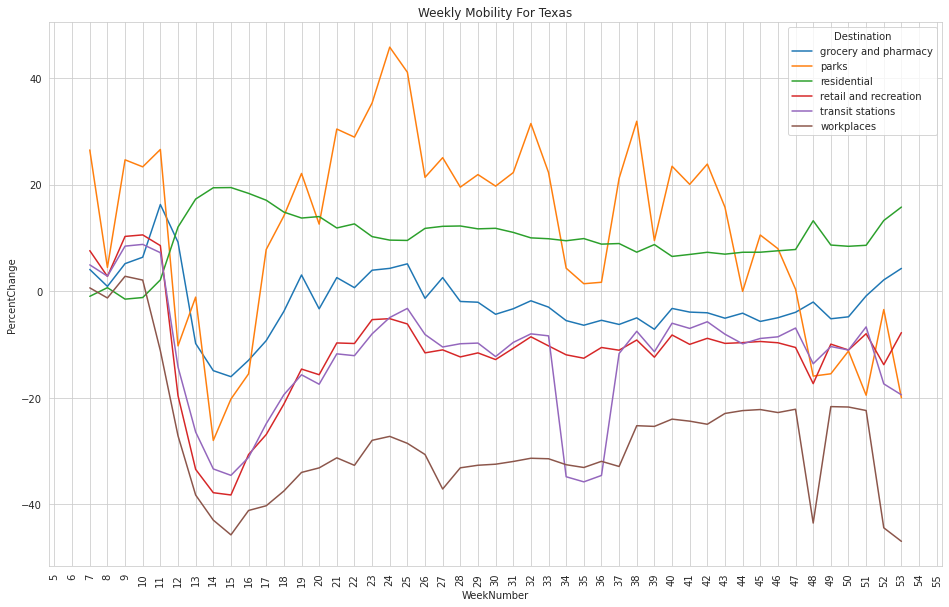

In [10]:
#set whitegrid to have grids in plots
sns.set_style("whitegrid")
#line plot that shows average mobility for the state of Texas during the year by week number
fig, ax=plt.subplots(figsize=(16,10))
scatter = sns.lineplot(x=mobility_txm.loc[mobility_txm['sub_region_1'] == 'Texas', 'WeekNumber'],
                             y=mobility_txm.loc[mobility_txm['sub_region_1'] == 'Texas', 'PercentChange'],
                             hue=mobility_txm['Destination'])
#customize the plot
plt.title("Weekly Mobility For Texas")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=100)

People in Texas spent more time at the parks during the pandemic and less time in the workplace.  We also saw a reduction in retail, recreation, and transit station visits.  The pharmacy and groceries remained close to the baseline. There was also an increase in the amount of time people spent at home.  

## Hypothesis Test 
### H0 = the mobility did not change from the baseline during March and April (Weeks 10 - 18)
### Ha = the mobility did decrease from the baseline during March and April

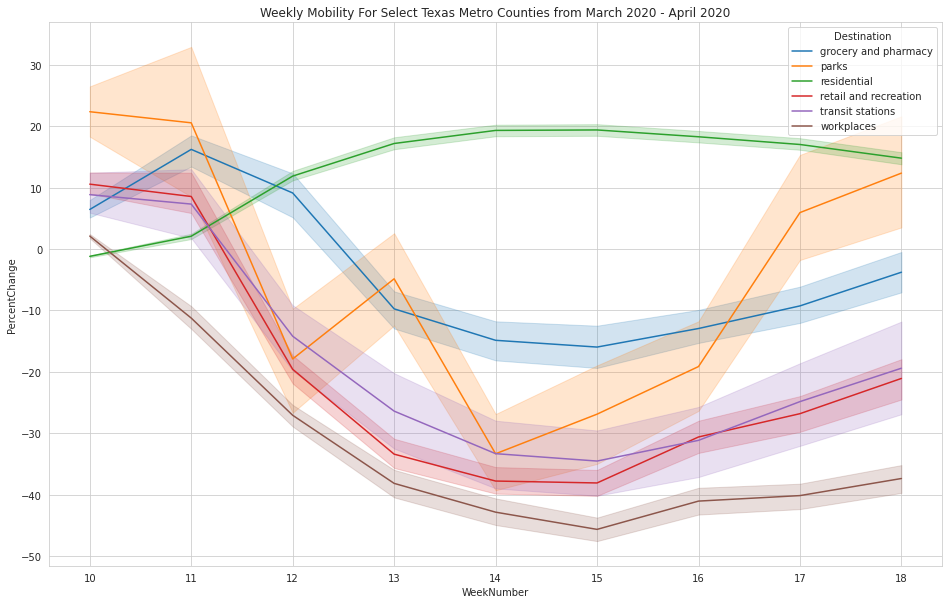

In [11]:
# Plot the Mobility Percent Change from the Baseline from the Shutdown Weeks (10-18) 
mobility_weeks = metro_county[(metro_county['WeekNumber'] >9) & (metro_county['WeekNumber'] < 19) ]
fig, ax=plt.subplots(figsize=(16,10))
scatter = sns.lineplot(x=mobility_weeks['WeekNumber'], y=mobility_weeks['PercentChange'],
                             hue=mobility_weeks['Destination'])
#customize the plot
plt.title("Weekly Mobility For Select Texas Metro Counties from March 2020 - April 2020")
plt.xticks(rotation=0)
plt.locator_params(axis='x', nbins=9)

In [12]:
#Percentage of null values in the Percent Change columns
print('Null values', mobility_weeks['PercentChange'].isna().sum()/mobility_weeks['PercentChange'].count())
#Drop the rows with null values
mobility_nonull = mobility_weeks.dropna()
#Percentage of null values in the Percent Change columns
print('Null values after dropping the nulls: ', mobility_nonull['PercentChange'].isna().sum()/mobility_nonull['PercentChange'].count())

Null values 0.12701252236135957
Null values after dropping the nulls:  0.0


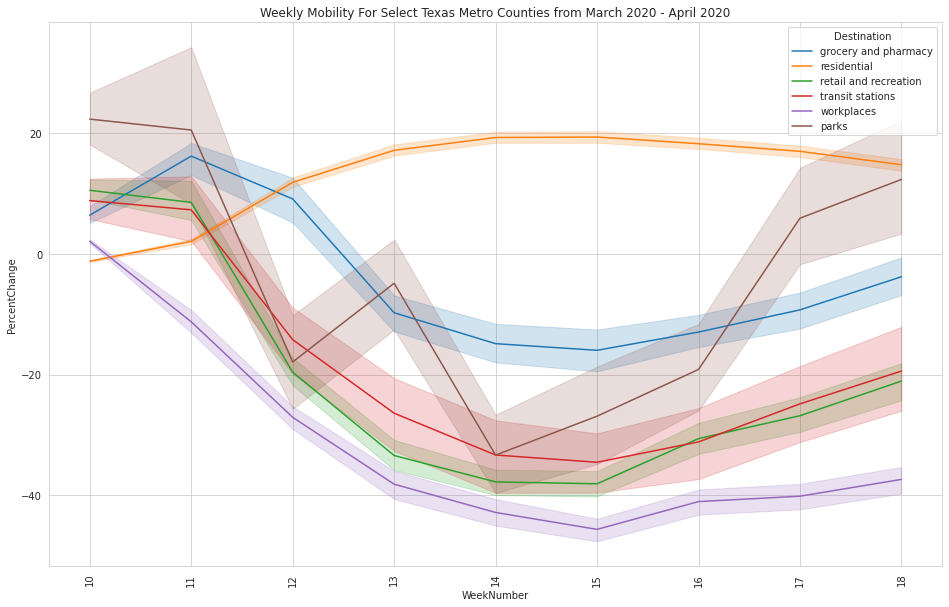

In [13]:
fig, ax=plt.subplots(figsize=(16,10))
scatter = sns.lineplot(x=mobility_nonull['WeekNumber'], y=mobility_nonull['PercentChange'],
                             hue=mobility_nonull['Destination'])
#customize the plot
plt.title("Weekly Mobility For Select Texas Metro Counties from March 2020 - April 2020")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=9)

In [14]:
# imports for Hypothesis testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests #this is for performing the pairwise tests

In [15]:
Weeks = [10, 11, 12, 13, 14, 15, 16, 17, 18]
Destinations = ['grocery and pharmacy', 'residential', 'retail and recreation', 'workplaces']
Results = []
for w in Weeks:
    for d in Destinations:
        T, p = stats.ttest_1samp(mobility_nonull[(mobility_nonull['WeekNumber']== w) & (mobility_nonull['Destination']== d)]['PercentChange'], popmean=0.0)
        Results.append(p/2)
                  

In [16]:
Results

[1.0905127351164752e-10,
 1.9570979164550813e-16,
 7.612542079456911e-14,
 3.152428597060435e-14,
 5.79438874194543e-14,
 3.5717177177301304e-11,
 6.45811923155815e-06,
 4.49573745697957e-14,
 1.0779723728490377e-05,
 2.762473579730545e-24,
 3.098195431086666e-18,
 6.942989033484197e-26,
 2.307576107858793e-07,
 3.039871567733957e-26,
 1.023641677679997e-24,
 7.108080772223577e-28,
 1.0172509337605979e-10,
 9.508013077039175e-28,
 4.25251003255449e-28,
 1.2565876456579061e-29,
 4.3094456801736274e-10,
 5.582678821736967e-28,
 9.089868039183146e-28,
 4.412179970429499e-32,
 1.0168792244858247e-10,
 2.8469201112642696e-27,
 4.210101290001463e-21,
 1.7198376512680887e-29,
 9.095756427194528e-07,
 6.07963497966752e-26,
 2.0792921345591626e-18,
 4.585558778441446e-29,
 0.014420376555214857,
 7.014726525823666e-24,
 2.979574554678385e-14,
 1.1628841342073342e-27]

In [21]:
groc = [Results[4*i] for i in range(0,9)]
resi = [Results[4*i+1] for i in range(0,9)]
retail = [Results[4*i+2] for i in range(0,9)]
work = [Results[4*i+3] for i in range(0,9)]
print('Maximum of Grocery P-values: ', max(groc))
print('Maximum of Residential P-values: ', max(resi))
print('Maximum of Retail P-values: ', max(retail))
print('Maximum of Working P-values: ', max(work))




Maximum of Grocery P-values:  0.014420376555214857
Maximum of Residential P-values:  3.5717177177301304e-11
Maximum of Retail P-values:  6.45811923155815e-06
Maximum of Working P-values:  4.49573745697957e-14


All of the P values are lower than the alpha = 0.05 for a one-sided T test. Thus we have to reject the null hypothesis that the mobility data was the same before the shutdowns as during. 